# CSC3831: Coursework Part II
**Note: You do not have to run the Model Tuning section, it takes a long time to run, especially on Google Colab. Also, running it again is not necessary as it it is only there to give the viewer an idea of how I decided to tweak the values of the hyperparameters.**

#### Install used packages:

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install evalml

## Read in the data

In [ ]:
import evalml

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.stats import pearsonr

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Utility

Functions that return the R<sup>2</sup> Score and the Root MSE of a model.

In [4]:
def calc_r2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)

def calc_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    return np.sqrt(mean_squared_error(y_test, y_pred))

Function that prints the performance metrics of a model and returns the Root MSE.

In [5]:
def evaluate(model, regression_type, X_test, y_test, ret=True):
    rmse = calc_rmse(model, X_test, y_test)
    r2 = calc_r2(model, X_test, y_test)
    
    print('{} Performance:'.format(regression_type))
    print('\tRoot MSE: {:0.4f}'.format(rmse))
    print('\tR2 Score: {:0.4f}\n'.format(r2))
    
    if ret:
        return rmse

Function that compares the Root MSEs of two models, used to compare base models to tuned models.

In [6]:
def compare(rmse1, rmse2):
    diff = 100 * (rmse2 - rmse1) / rmse1
    
    if diff >=0:
        print('Increase of Root MSE by {:0.2f}%'.format(np.abs(diff)))
    else:
        print('Decrease of Root MSE by {:0.2f}%'.format(np.abs(diff)))

Function to compare the metrics of two models:

In [7]:
def compare_models(model1, model2, model_name1, model_name2, X_test, y_test):
    r21 = calc_r2(model1, X_test, y_test)
    r22 = calc_r2(model2, X_test, y_test)

    rmse1 = calc_rmse(model1, X_test, y_test)
    rmse2 = calc_rmse(model2, X_test, y_test)

    diff_r2 = 100 * (r22 - r21) / r21
    diff_rmse = 100 * (rmse2 - rmse1) / rmse1

    print('{} gives {:0.2f}% better R2 Score than {}'.format(model_name2, diff_r2, model_name1))
    print('{} gives {:0.2f}% higher Root MSE than {}\n'.format(model_name2, diff_rmse, model_name1))

## Pre-Processing

### Normalising Features

In [8]:
houses['rooms_per_household'] = houses['total_rooms'] / houses['households']
houses['bedrooms_per_household'] = houses['total_bedrooms'] / houses['households']
houses['people_per_household'] = houses['population'] / houses['households']

### Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
houses_scaled = scaler.fit_transform(houses)
houses_scaled = pd.DataFrame(houses_scaled, columns=houses.columns)

### Splitting the Data

In [10]:
X = houses_scaled.drop(columns=['median_house_value'])
y = houses_scaled['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Deciding on the Regression Methods

In order to decide which four regression methods will be used, we will make use of the evalml package, which will give us, in order, the most appropriate methods to perform regression on the dataset.

In [11]:
from evalml.automl import AutoMLSearch

automl = AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='regression')
automl.search()
automl.rankings

,id,pipeline_name,search_order,validation_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,7,XGBoost Regressor w/ Replace Nullable Types Tr...,7,0.824934,0.824934,0.008906,74940.825324,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,9,LightGBM Regressor w/ Replace Nullable Types T...,9,0.745301,0.745301,0.006763,67716.235060,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,2,Random Forest Regressor w/ Replace Nullable Ty...,2,0.698046,0.698046,0.007323,63429.058253,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,4,Random Forest Regressor w/ Replace Nullable Ty...,4,0.697092,0.697092,0.006546,63342.524559,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,5,Decision Tree Regressor w/ Replace Nullable Ty...,5,0.636033,0.636033,0.015918,57803.051857,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,1,Elastic Net Regressor w/ Replace Nullable Type...,1,0.632205,0.632205,0.006610,57455.785132,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,3,Elastic Net Regressor w/ Replace Nullable Type...,3,0.595169,0.595169,0.010233,54095.750086,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,6,Extra Trees Regressor w/ Replace Nullable Type...,6,0.579309,0.579309,0.006124,52656.851612,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,8,CatBoost Regressor w/ Replace Nullable Types T...,8,0.259544,0.259544,0.003327,23646.707707,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,0,Mean Baseline Regression Pipeline,0,-0.001102,-0.001102,0.000960,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


These are the ten best regression models for the dataset according to evalml. Most of these are ensemble techniques (XGBoost, Random Forest, CatBoost, Extra Trees, LightGBM). For that reason, I will pick two regression models from this list (one ensemble and one linear), as well as two that are not on the list.


The regression methods that will be used are the following:

1. Random Forest: Ensemble method, one of the top picks.
1. Elastic Net: Linear method, mid-low on the list.
1. Support Vector: Not included in the list.
1. K-Nearest Neighbours: Not included in the list.

## Model Tuning

### First Model: Random Forest

#### Base Model

In [12]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
base_forest_rmse = evaluate(forest, 'Random Forest Base Model', X_test, y_test)

Random Forest Base Model Performance:
	Root MSE: 0.4281
	R2 Score: 0.8170



#### Trying different hyperparameters using Randomized Search Cross-Validation to narrow down the values for hyperparameters

In [13]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['log2', 'sqrt', None]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}


rscv_forest = RandomForestRegressor()
rscvf = RandomizedSearchCV(estimator=rscv_forest, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rscvf.fit(X_train, y_train)

print('Best Parameters:\n' + str(rscvf.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


Comparing default parameter training with the best parameters according to the random search:

In [14]:
best_random_forest = rscvf.best_estimator_
random_rmse_forest = evaluate(best_random_forest, 'Random Forest Best Random Search Model', X_test, y_test)

compare(base_forest_rmse, random_rmse_forest)

Random Forest Best Random Search Model Performance:
	Root MSE: 0.4199
	R2 Score: 0.8239

Decrease of Root MSE by 1.92%


#### Now that we have a general idea of what the best parameters are thanks to our Randomised Search CV, perform a Grid Search:

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [900, 1000, 1100],
    'max_features': ['log2'],
    'max_depth': [100, 120, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [False]
}


gscv_forest = RandomForestRegressor()
gscvf = GridSearchCV(estimator=gscv_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gscvf.fit(X_train, y_train)

print('Best Parameters:\n' + str(gscvf.best_params_))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters:
{'bootstrap': False, 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1100}


Compare the final results of the search with the base model:

In [16]:
best_search_forest = gscvf.best_estimator_
search_rmse_forest = evaluate(best_search_forest, 'Random Forest Best Grid Search Model', X_test, y_test)

compare(base_forest_rmse, search_rmse_forest)

Random Forest Best Grid Search Model Performance:
	Root MSE: 0.4197
	R2 Score: 0.8242

Decrease of Root MSE by 1.98%


#### The evalml package also provides utility for finding the best parameters for the list of best models from before. Let's see what it suggests.

In [20]:
forest_pipeline = automl.get_pipeline(2)
forest_pipeline.parameters['Random Forest Regressor']

{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}

Now, train the model using these hyperparameters:

In [21]:
tuned_forest = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=-1)
tuned_forest.fit(X_train, y_train)
tuned_forest_rmse = evaluate(tuned_forest, 'Random Forest AutoML-Tuned Model', X_test, y_test)
compare(base_forest_rmse, tuned_forest_rmse)

Random Forest AutoML-Tuned Model Performance:
	Root MSE: 0.5467
	R2 Score: 0.7016

Increase of Root MSE by 27.70%


The evalml package's best model is much worse than the base model, so we will move forward with best_search_forest as the best model for Random Forest Regression.

### Second Model: Elastic Net

#### Base Model

In [22]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet()
elnet.fit(X_train, y_train)
base_elnet_rmse = evaluate(elnet, 'Elastic Net Base Model', X_test, y_test)

Elastic Net Base Model Performance:
	Root MSE: 0.9192
	R2 Score: 0.1564



#### Since Elastic Net works fast, there is no need to run a random search to narrow down the hyperparameters first.

In [23]:
from sklearn.model_selection import GridSearchCV

alpha = np.arange(start=0.1, stop=2.0, step=0.2)

l1_ratio = np.arange(start=0.1, stop=1, step=0.2)

fit_intercept = [True, False]

max_iter = [int(x) for x in np.linspace(start=400, stop=2000, num=9)]

selection = ['cyclic', 'random']

param_grid = {
    'alpha': alpha,
    'l1_ratio': l1_ratio,
    'fit_intercept': fit_intercept,
    'max_iter': max_iter,
    'selection': selection
}

gscv_elnet = ElasticNet()
gscven = GridSearchCV(estimator=gscv_elnet, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gscven.fit(X_train, y_train)

print('Best Parameters:\n' + str(gscven.best_params_))

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits
Best Parameters:
{'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.1, 'max_iter': 400, 'selection': 'random'}


Compare the final results of the search with the base model:

In [24]:
best_search_elnet = gscven.best_estimator_
search_rmse_elnet = evaluate(best_search_elnet, 'Elastic Net Best Grid Search Model', X_test, y_test)

compare(base_elnet_rmse, search_rmse_elnet)

Elastic Net Best Grid Search Model Performance:
	Root MSE: 0.6404
	R2 Score: 0.5906

Decrease of Root MSE by 30.33%


#### The evalml package also provides utility for finding the best parameters for the list of best models from before. Let's see if we can get better results using it.

In [25]:
elnet_pipeline = automl.get_pipeline(1)
elnet_pipeline.parameters['Elastic Net Regressor']

{'alpha': 0.0001, 'l1_ratio': 0.15, 'max_iter': 1000, 'normalize': False}

Now, train the model using these hyperparameters:

In [26]:
tuned_elnet = ElasticNet(alpha=0.0001, l1_ratio=0.15, max_iter=1000, normalize=False)
tuned_elnet.fit(X_train, y_train)
tuned_elnet_rmse = evaluate(tuned_elnet, 'Elastic Net AutoML-Tuned Model', X_test, y_test)
compare(base_elnet_rmse, tuned_elnet_rmse)

Elastic Net AutoML-Tuned Model Performance:
	Root MSE: 0.5946
	R2 Score: 0.6470

Decrease of Root MSE by 35.32%


The evalml package's best model better than the best grid search model I found, most likely owing to the fact that the lowest value I gave for alpha was 0.1, whereas evalml gave it 0.0001. Therefore the model we will be moving forward with for Elastic Net Regression is tuned_elnet.

Elastic Net saw the greatest increase in R<sup>2</sup> Score and decrease of Root MSE of all models by a huge margin.

### Third Model: Support Vector

#### Base Model

In [27]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
base_svr_rmse = evaluate(svr, 'Support Vector Base Model', X_test, y_test)

Support Vector Base Model Performance:
	Root MSE: 0.4884
	R2 Score: 0.7618



#### Trying different hyperparameters using Randomized Search Cross-Validation to narrow down the values for hyperparameters


In [28]:
from sklearn.model_selection import RandomizedSearchCV

# 'precomputed' is not included because it crashes the search
# 'poly' is not included because using it takes way too much time
# also, after trying it once, poly was not the best option anyway
kernel = ['linear', 'rbf', 'sigmoid']

gamma = ['scale', 'auto']

epsilon = np.arange(start=0.1, stop=0.6, step=0.1)

shrinking = [True, False]

cache_size = [int(x) for x in np.linspace(start=200, stop=1000, num=9)]

random_grid = {
    'kernel': kernel,
    'gamma': gamma,
    'epsilon': epsilon,
    'shrinking': shrinking,
    'cache_size': cache_size
}


rscv_svr = SVR()
rscvsvr = RandomizedSearchCV(estimator=rscv_svr, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rscvsvr.fit(X_train, y_train)

print('Best Parameters:\n' + str(rscvsvr.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters:
{'shrinking': False, 'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.2, 'cache_size': 700}


In [29]:
best_random_svr = rscvsvr.best_estimator_
random_rmse_svr = evaluate(best_random_svr, 'Support Vector Best Random Search Model', X_test, y_test)

compare(base_svr_rmse, random_rmse_svr)

Support Vector Best Random Search Model Performance:
	Root MSE: 0.4872
	R2 Score: 0.7630

Decrease of Root MSE by 0.25%


#### Now that we have a general idea of what the best parameters are thanks to our Randomised Search CV, perform a Grid Search:

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3],
    'shrinking': [False, True],
    'cache_size': [200, 600, 700, 800]
}

gscv_svr = SVR()
gscvsvr = GridSearchCV(estimator=gscv_svr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gscvsvr.fit(X_train, y_train)

print('Best Parameters:\n' + str(gscvsvr.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters:
{'cache_size': 200, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False}


Compare the final results of the search with the base model:

In [31]:
best_search_svr = gscvsvr.best_estimator_
search_rmse_svr = evaluate(best_search_svr, 'Support Vector Best Grid Search Model', X_test, y_test)

compare(base_svr_rmse, search_rmse_svr)

Support Vector Best Grid Search Model Performance:
	Root MSE: 0.4872
	R2 Score: 0.7630

Decrease of Root MSE by 0.25%


SVR saw the smallest improvement of all models, but an improvement nonetheless.

### Fourth Model: K-Nearest Neighbours

#### Base Model

In [32]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
base_knn_rmse = evaluate(knn, 'K-Nearest Neighbours Base Model', X_test, y_test)

K-Nearest Neighbours Base Model Performance:
	Root MSE: 0.5308
	R2 Score: 0.7187



#### Since K-Nearest Neighbours works fast, there is no need to run a random search to narrow down the hyperparameters first.

In [33]:
from sklearn.model_selection import GridSearchCV

n_neighbors = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
n_neighbors.append(5)

weights = ['uniform', 'distance']

algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

leaf_size = [20, 30, 40, 50]

param_grid = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'algorithm': algorithm,
    'leaf_size': leaf_size
}

gscv_knn = KNeighborsRegressor()
gscvknn = GridSearchCV(estimator=gscv_knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gscvknn.fit(X_train, y_train)

print('Best Parameters:\n' + str(gscvknn.best_params_))

Fitting 3 folds for each of 352 candidates, totalling 1056 fits
Best Parameters:
{'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 10, 'weights': 'distance'}


Compare the final results of the search with the base model:

In [34]:
best_search_knn = gscvknn.best_estimator_
search_rmse_knn = evaluate(best_search_knn, 'K-Nearest Neighbours Best Grid Search Model', X_test, y_test)

compare(base_knn_rmse, search_rmse_knn)

K-Nearest Neighbours Best Grid Search Model Performance:
	Root MSE: 0.5163
	R2 Score: 0.7338

Decrease of Root MSE by 2.72%


## Model Training

Let's rebuild all base and final models, so we do not have to run the previous part of the notebook each time. If the Model Training section is run it is likely some hyperparameters differ slightly, but the performance of each model would not be that much different and not running that section saves a lot of time.

### Random Forest Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

base_forest = RandomForestRegressor()
base_forest.fit(X_train, y_train)

final_forest = RandomForestRegressor(n_estimators=1100, max_depth=100, max_features='log2', min_samples_split=4, min_samples_leaf=1, bootstrap=False)
final_forest.fit(X_train, y_train)

base_forest_rmse = evaluate(base_forest, 'Base Random Forest', X_test, y_test)
tuned_forest_rmse = evaluate(final_forest, 'Tuned Random Forest', X_test, y_test)

compare(base_forest_rmse, tuned_forest_rmse)

Base Random Forest Performance:
	Root MSE: 0.4285
	R2 Score: 0.8167

Tuned Random Forest Performance:
	Root MSE: 0.4198
	R2 Score: 0.8240

Decrease of Root MSE by 2.03%


### Elastic Net Regression

In [36]:
from sklearn.linear_model import ElasticNet

base_elnet = ElasticNet()
base_elnet.fit(X_train, y_train)

final_elnet = ElasticNet(alpha=0.0001, l1_ratio=0.15, max_iter=1000, normalize=False)
final_elnet.fit(X_train, y_train)

base_elnet_rmse = evaluate(base_elnet, 'Base Elastic Net', X_test, y_test)
tuned_elnet_rmse = evaluate(final_elnet, 'Tuned Elastic Net', X_test, y_test)

compare(base_elnet_rmse, tuned_elnet_rmse)

Base Elastic Net Performance:
	Root MSE: 0.9192
	R2 Score: 0.1564

Tuned Elastic Net Performance:
	Root MSE: 0.5946
	R2 Score: 0.6470

Decrease of Root MSE by 35.32%


### Support Vector Regression

In [37]:
from sklearn.svm import SVR

base_svr = SVR()
base_svr.fit(X_train, y_train)

final_svr = SVR(cache_size=200, epsilon=0.2, gamma='auto', kernel='rbf', shrinking=False)
final_svr.fit(X_train, y_train)

base_svr_rmse = evaluate(base_svr, 'Base Support Vector', X_test, y_test)
tuned_svr_rmse = evaluate(final_svr, 'Tuned Support Vector', X_test, y_test)

compare(base_svr_rmse, tuned_svr_rmse)

Base Support Vector Performance:
	Root MSE: 0.4884
	R2 Score: 0.7618

Tuned Support Vector Performance:
	Root MSE: 0.4872
	R2 Score: 0.7630

Decrease of Root MSE by 0.25%


### K-Nearest Neighbours Regression

In [38]:
from sklearn.neighbors import KNeighborsRegressor

base_knn = KNeighborsRegressor()
base_knn.fit(X_train, y_train)

final_knn = KNeighborsRegressor(n_neighbors=10, algorithm='auto', leaf_size=20, weights='distance')
final_knn.fit(X_train, y_train)

base_knn_rmse = evaluate(base_knn, 'Base K-Nearest Neighbours', X_test, y_test)
tuned_knn_rmse = evaluate(final_knn, 'Tuned K-Nearest Neighbours', X_test, y_test)

compare(base_knn_rmse, tuned_knn_rmse)

Base K-Nearest Neighbours Performance:
	Root MSE: 0.5308
	R2 Score: 0.7187

Tuned K-Nearest Neighbours Performance:
	Root MSE: 0.5163
	R2 Score: 0.7338

Decrease of Root MSE by 2.72%


## Model Comparison

Analysis of results so far:
* The best results were given by the Random Forest, with it having the highest R<sup>2</sup> Score and the lowest Root MSE. This does not come as a surprise, as the evalml package mostly recommended ensemble models. 
* The second best model was Support Vector, followed fairly closely by K-Nearest Neighbours. 
* While Elastic Net remains in last place even after being tuned, it saw such an increase in R<sup>2</sup> Score as to not be leagues worse than the other models as was true for the base model.

### R<sup>2</sup> and Root MSE Bar Chart

Next, let's compare all of the models' R<sup>2</sup> Scores and Root MSEs to each other:

In [39]:
compare_models(final_forest, final_elnet, 'Random Forest', 'Elastic Net', X_test, y_test)
compare_models(final_forest, final_svr, 'Random Forest', 'Support Vector', X_test, y_test)
compare_models(final_forest, final_knn, 'Random Forest', 'K-Nearest Neighbours', X_test, y_test)
compare_models(final_elnet, final_svr, 'Elastic Net', 'Support Vector', X_test, y_test)
compare_models(final_elnet, final_knn, 'Elastic Net', 'K-Nearest Neighbours', X_test, y_test)
compare_models(final_svr, final_knn, 'Support Vector', 'K-Nearest Neighbours', X_test, y_test)

Elastic Net gives -21.48% better R2 Score than Random Forest
Elastic Net gives 41.63% higher Root MSE than Random Forest

Support Vector gives -7.40% better R2 Score than Random Forest
Support Vector gives 16.04% higher Root MSE than Random Forest

K-Nearest Neighbours gives -10.95% better R2 Score than Random Forest
K-Nearest Neighbours gives 22.99% higher Root MSE than Random Forest

Support Vector gives 17.93% better R2 Score than Elastic Net
Support Vector gives -18.06% higher Root MSE than Elastic Net

K-Nearest Neighbours gives 13.41% better R2 Score than Elastic Net
K-Nearest Neighbours gives -13.16% higher Root MSE than Elastic Net

K-Nearest Neighbours gives -3.83% better R2 Score than Support Vector
K-Nearest Neighbours gives 5.98% higher Root MSE than Support Vector



Let's visualise the above information in a bar chart:

In [40]:
model_names = ['Random Forest', 'Elastic Net', 'Support Vector', 'K-Nearest Neighbours']
model_types = ['Base', 'Tuned']
base_models = [base_forest, base_elnet, base_svr, base_knn]
tuned_models = [final_forest, final_elnet, final_svr, final_knn]

base_scores = []
base_rmses = []

tuned_scores = []
tuned_rmses = []

for m in base_models:
    base_scores.append(calc_r2(m, X_test, y_test))
    base_rmses.append(calc_rmse(m, X_test, y_test))
    
for m in tuned_models:
    tuned_scores.append(calc_r2(m, X_test, y_test))
    tuned_rmses.append(calc_rmse(m, X_test, y_test))
    
scores = [base_scores, tuned_scores]
rmses = [base_rmses, tuned_rmses]

base_models = np.array(base_models, dtype=object).reshape((2, 2))
tuned_models = np.array(tuned_models, dtype=object).reshape((2, 2))

base_scores = np.array(base_scores, dtype=float).reshape((2, 2))
base_rmses = np.array(base_rmses, dtype=float).reshape((2, 2))

tuned_scores = np.array(tuned_scores, dtype=float).reshape((2, 2))
tuned_rmses = np.array(tuned_rmses, dtype=float).reshape((2, 2))

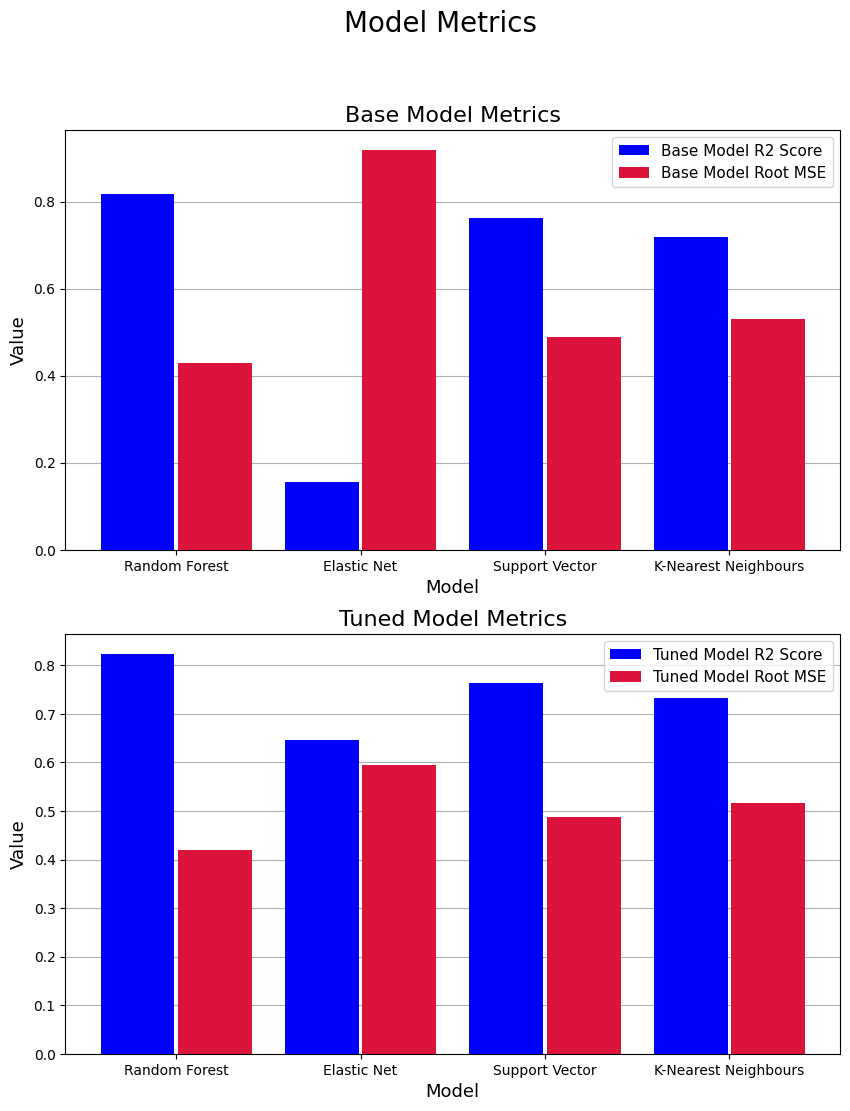

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle('Model Metrics', fontsize=20)

X_axis = np.arange(len(model_names))

for i in range(2):
    ax[i].bar(X_axis-0.21, scores[i], 0.4, label=f'{model_types[i]} Model R2 Score', color='blue', zorder=5)
    ax[i].bar(X_axis+0.21, rmses[i], 0.4, label=f'{model_types[i]} Model Root MSE', color='crimson', zorder=5)
    
    ax[i].set_xticks(X_axis, model_names)
    ax[i].set_xlabel('Model', fontsize=13)
    ax[i].set_ylabel('Value', fontsize=13)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_title(f'{model_types[i]} Model Metrics', fontsize=16)
    ax[i].grid(axis='y', zorder=3)
    ax[i].legend(prop={'size': 11})
    
plt.show()

The bar charts show the R<sup>2</sup> Score and Root MSE of every model before and after being tuned. Because the improvement experienced by most models after being tuned is small, the bars do not look too different. Once again, we can see Elastic Net's extraordinary R<sup>2</sup> Score boost after tuning.

### Real vs Predicted Values Scatter Plot

In [42]:
model_names = np.array(model_names).reshape(2, 2)

predictions = np.empty(dtype=pd.Series, shape=(2, 2))

for i in range(2):
    for j in range(2):
        predictions[i, j] = base_models[i, j].predict(X_test)

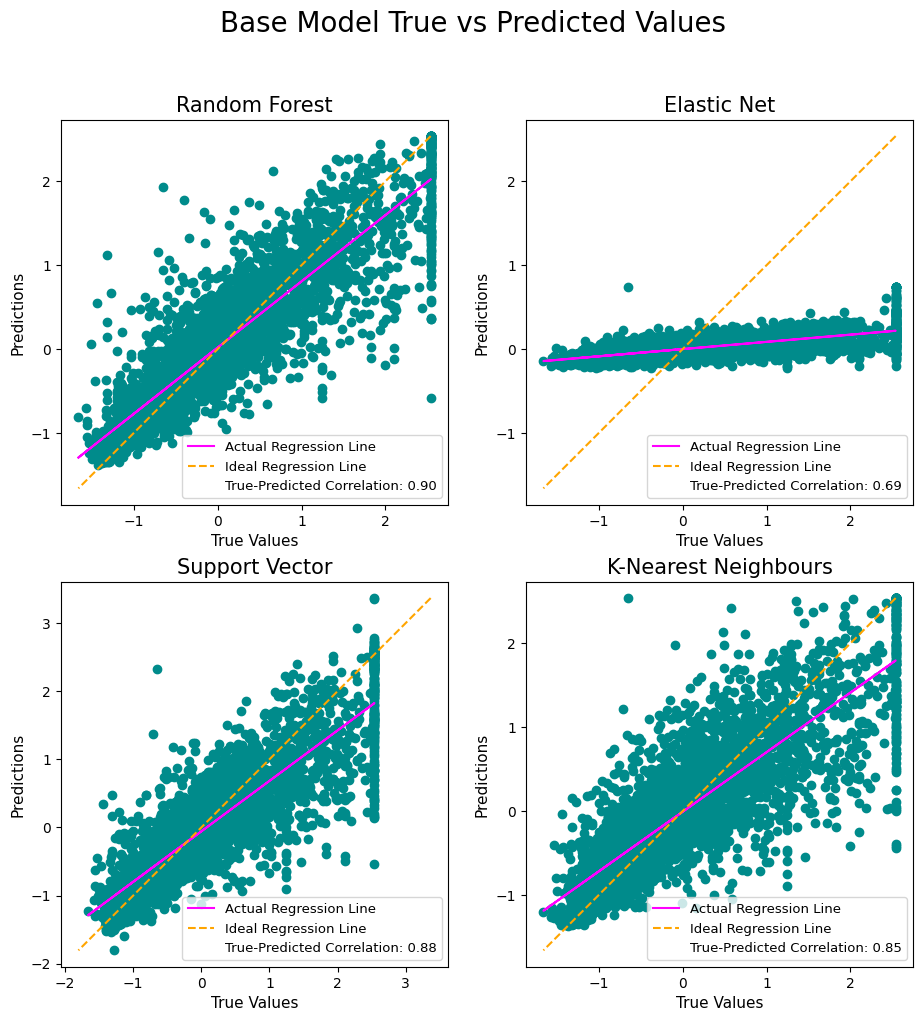

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
fig.suptitle('Base Model True vs Predicted Values', fontsize=20)

for i in range(2):
    for j in range(2):
        ax[i, j].scatter(y_test, predictions[i, j], color='darkcyan')
        
        gradient, intercept = np.polyfit(y_test, predictions[i, j], 1)
        ax[i, j].plot(y_test, gradient * y_test + intercept, color='magenta', label='Actual Regression Line')
        
        p1 = max(max(predictions[i, j]), max(y_test))
        p2 = min(min(predictions[i, j]), min(y_test))
        
        ax[i, j].plot([p1, p2], [p1, p2], color='orange', linestyle='--', label='Ideal Regression Line')
        ax[i, j].plot([], [], alpha=0, label='True-Predicted Correlation: {:.2f}'.format(pearsonr(predictions[i, j], y_test)[0]))
        
        ax[i, j].set_title(model_names[i, j], fontsize=15)
        ax[i, j].set_xlabel('True Values', fontsize=11)
        ax[i, j].set_ylabel('Predictions', fontsize=11)
        ax[i, j].axis('equal')
        ax[i, j].legend(loc=4, prop={'size': 9.5})
        
plt.show()

In [44]:
predictions = np.empty(dtype=pd.Series, shape=(2, 2))

for i in range(2):
    for j in range(2):
        predictions[i, j] = tuned_models[i, j].predict(X_test)

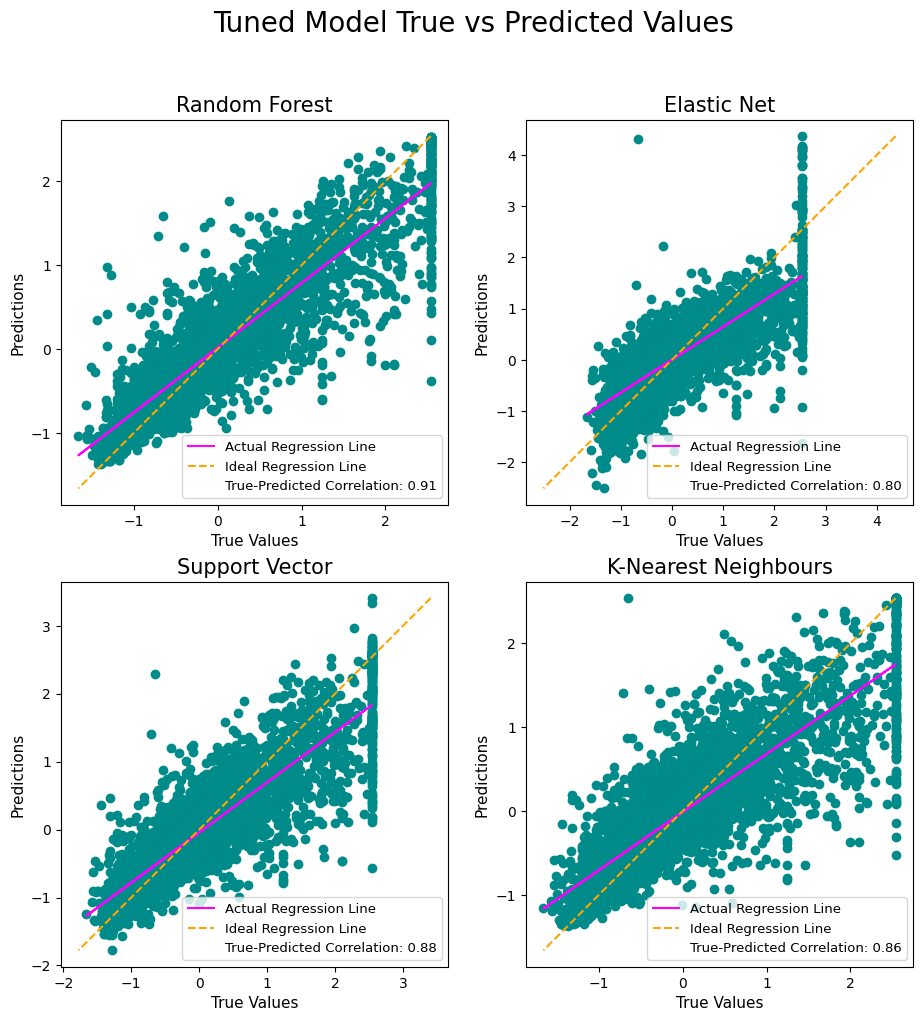

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
fig.suptitle('Tuned Model True vs Predicted Values', fontsize=20)

for i in range(2):
    for j in range(2):
        ax[i, j].scatter(y_test, predictions[i, j], color='darkcyan')
        
        gradient, intercept = np.polyfit(y_test, predictions[i, j], 1)
        ax[i, j].plot(y_test, gradient * y_test + intercept, color='magenta', label='Actual Regression Line')
        
        p1 = max(max(predictions[i, j]), max(y_test))
        p2 = min(min(predictions[i, j]), min(y_test))
        
        ax[i, j].plot([p1, p2], [p1, p2], color='orange', linestyle='--', label='Ideal Regression Line')
        ax[i, j].plot([], [], alpha=0, label='True-Predicted Correlation: {:.2f}'.format(pearsonr(predictions[i, j], y_test)[0]))
        
        ax[i, j].set_title(model_names[i, j], fontsize=15)
        ax[i, j].set_xlabel('True Values', fontsize=11)
        ax[i, j].set_ylabel('Predictions', fontsize=11)
        ax[i, j].axis('equal')
        ax[i, j].legend(loc=4, prop={'size': 9.5})
        
plt.show()

Again, for most models the difference is minimal (in the case of SVR it's possible the correlation value the same because it is printed with a precision of 2 decimals), but we can see a huge different in the Elastic Net scatter plot. This plot clearly shows which model did the best in terms of predicting values.

## Conclusion

The regression models used to train the california housing dataset for predicting the median_house_value of an area in this notebook were Random Forest, Elastic Net, Support Vector and K-Nearest Neighbours:

Out of these, Random Forest is undoubtedly the best one to use. It achieves a higher R<sup>2</sup> Score and lower Root MSE than all other models even with the base model. Furthermore, while Support Vector and K-Nearest Neighbours provide us with R<sup>2</sup> Scores that are somewhat close to Random Forest's, its Root MSE is lower by a notable amount. This fact is reinforced by looking at the charts in the Comparison section.